In [8]:
%reset -f
# import the necessary packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import random
import cv2, glob, git
import os
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset
from insectrec.utils import get_dataset

seed = 42
np.random.seed(seed)
batch_size = 32

repo = git.Repo('.', search_parent_directories=True)
created_data_path = f'{repo.working_tree_dir}/insectrec/created_data'
path_impy_crops_export = f'{created_data_path}/impy_crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'
img_dim = 90
modelname = f'fuji_{img_dim}'

In [9]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_orig = pd.DataFrame()
df_orig['x'] = pd.Series(glob.glob(f"{path_impy_crops_export}/*/*.jpg"))
df_orig['y_text'] = df_orig['x'].apply(lambda x: x.split('/')[-2])
df_orig['y'] = le.fit_transform(df_orig.y_text)

# Splitting into train/val/test
X_train, X_test, y_train, y_test = train_test_split(df_orig.x, df_orig.y, test_size=0.2, random_state=seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

X_test = X_test.tolist()
y_test = y_test.tolist()

## DenseNet121 trained from scratch

In [10]:
base_model = DenseNet121(include_top=True, weights=None, 
                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = Dropout(0.5)(x)
# x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

In [11]:
import math
top_weights_path = f'./insectrec/created_data/weights/model_{modelname}.h5'
model.load_weights(top_weights_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
y_pred = model.predict_generator(valid_generator(X_test, y_test, batch_size=batch_size, nb_classes=6, img_dim=img_dim), 
                         steps= len(X_test) / batch_size, 
                         verbose=1)
print(y_pred.shape)
y_pred = np.argmax(y_pred, axis=1)

75/74 [==============================] - 7s 92ms/step
(2383, 6)


In [13]:
name_map = dict(zip(le.transform(le.classes_), le.classes_))
name_map

{0: 'bl', 1: 'c', 2: 'm', 3: 'v', 4: 'v(cy)', 5: 'wmv'}

0.7265661868320953


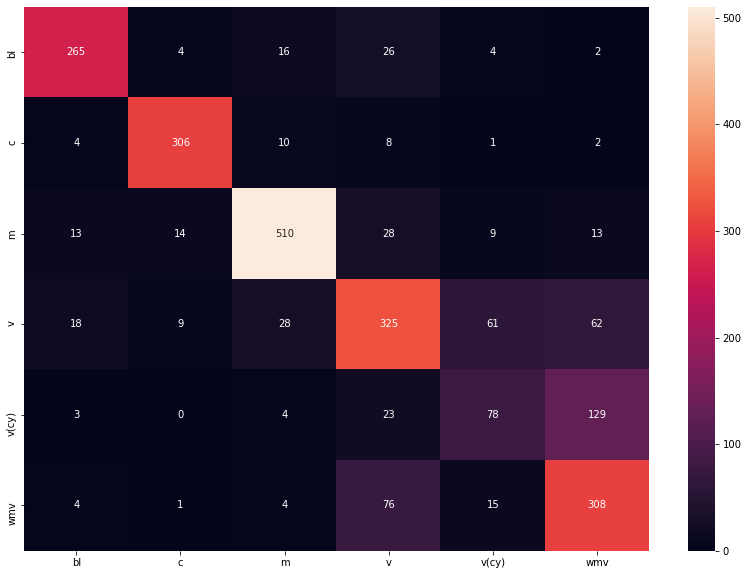

In [14]:
print(balanced_accuracy_score(y_test, y_pred))
plt.figure(figsize=(14,10))
sns.heatmap(confusion_matrix(le.fit_transform(y_test), y_pred), annot=True, fmt='.0f', xticklabels=list(name_map.values()), yticklabels=list(name_map.values()))